<a href="https://colab.research.google.com/github/KevinTheRainmaker/AI-ML_Team_5/blob/main/KangbeenKo/Kaggle02_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Novice to Grandmaster
### Competition #2: Natural Language Processing with Disaster Tweets

- https://www.kaggle.com/c/nlp-getting-started

[설명]

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/Kaggle'

Mounted at /content/drive


In [2]:
# Packages

# Pyhton's Basic packages
import os

import pandas as pd
import numpy as np
import math, re, time, random, string
from itertools import islice

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# No Warnings
import warnings
warnings.filterwarnings(action='ignore')

# for NLP
from collections import defaultdict
import wordcloud

# install nltk
!pip install -U -q nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

#install autocorrect
!pip install -q autocorrect
from autocorrect import Speller 

# to see progress
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

# for model construction
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from keras.models import Model

from sklearn.model_selection import train_test_split

# Kaggle API Set-up
!pip install -q --upgrade --force-reinstall --no-deps kaggle
os.environ['KAGGLE_USERNAME'] = 'kangbeenko'
os.environ['KAGGLE_KEY'] = '7bf5875a0067e432fb8a9300acd60b8e'

     |████████████████████████████████| 1.5 MB 26.2 MB/s 
     |████████████████████████████████| 749 kB 48.1 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


     |████████████████████████████████| 622 kB 27.2 MB/s 


0it [00:00, ?it/s]


     |████████████████████████████████| 58 kB 5.5 MB/s 


## Dataset

In [3]:
!kaggle competitions download -c nlp-getting-started
!mv nlp-getting-started.zip drive/MyDrive/data/Kaggle/

100% 593k/593k [00:00<00:00, 4.05MB/s]
100% 593k/593k [00:00<00:00, 4.04MB/s]


In [4]:
!unzip drive/MyDrive/data/Kaggle/nlp-getting-started.zip

Archive:  drive/MyDrive/data/Kaggle/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!unzip drive/MyDrive/data/Kaggle/glove.twitter.27B.zip

Archive:  drive/MyDrive/data/Kaggle/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [77]:
train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

print("Trainset counts: ", train_df['id'].count())
print("Testset counts: ", test_df['id'].count())

Trainset counts:  7613
Testset counts:  3263


In [78]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [79]:
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


target이 1이면 disaster tweet이고, 0인 경우 disaster tweet이 아니다.

In [80]:
print(train_df[train_df["target"] == 0]["text"].values[1])
print(train_df[train_df["target"] == 1]["text"].values[1])

I love fruits
Forest fire near La Ronge Sask. Canada


In [81]:
print(train_df[train_df["keyword"].notnull()].iloc[0])

id                                                         48
keyword                                                ablaze
location                                           Birmingham
text        @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                      1
Name: 31, dtype: object


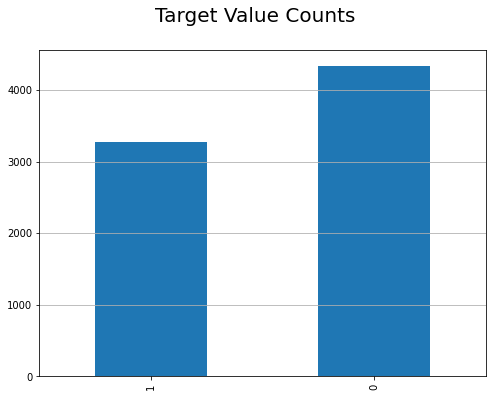

In [82]:
# Plotting target value counts
plt.figure(figsize=(8,6))
ax = train_df['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

In [83]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

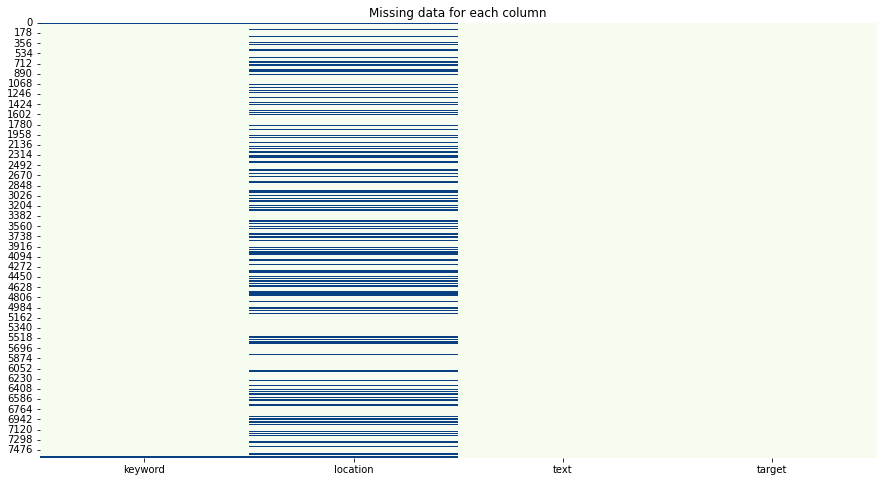

In [84]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

In [85]:
lengths = np.array([len(x) for x in train_df['text']])
print(np.mean(lengths), np.median(lengths))

101.03743596479706 107.0


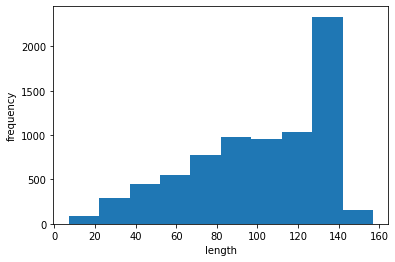

In [86]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

## Cleaning

In [87]:
# create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

# showcase spellcheck 
mispelled = 'Pleaze spel check this sentince'
spell_check(mispelled)

'Please spell check this sentence'

In [88]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def clean_text(x):
    # remove URL from text
    x_no_url = re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.IGNORECASE|re.MULTILINE)
    
    # remove numbers from text
    x_no_num = re.sub(r'\d+', '', x_no_url)

    # remove shortwords from text
    x_no_short = re.sub(r'\W*\b\w{1,2}\b', '', x_no_num)

    # tokenize each text
    word_tokens = word_tokenize(x_no_short)
    
    # remove spatial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    x_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in x_with_no_stop_word]

    # do lemmatization
    lemmatized_text = [lemmatizer.lemmatize(w, 'v') for w in stemmed_text]
    
    return " ".join(" ".join(lemmatized_text).split())

In [89]:
total = [train_df, test_df]
for dataset in total:
    #apply all of above functions
    dataset['keyword'].fillna('none', inplace=True)
    dataset['clean_text'] = dataset['text'].progress_apply(clean_text)
    dataset['clean_keyword'] = dataset['keyword'].progress_apply(clean_text)
    dataset['keyword_text'] = dataset['clean_keyword'] + " " + dataset["clean_text"]
    dataset['keyword_text'] = dataset['keyword_text'].progress_apply(spell_check)

100%|██████████| 3263/3263 [13:43<00:00,  3.96it/s]


In [90]:
train_df[:5]

,id,keyword,location,text,target,clean_text,clean_keyword,keyword_text
0,1,none,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv,none,none our deed reason earthquake may alla forgive
1,4,none,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada,none,none forest fire near song task canada
2,5,none,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic evacu...,none,none all revid ask shelter place notify office...
3,6,none,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,none,none people receive wildfire evac order califo...
4,7,none,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get send photo rubi alaska smoke wildfir ...,none,none just get send photo rub alaska smoke wild...


In [91]:
test_df[:5]

,id,keyword,location,text,clean_text,clean_keyword,keyword_text
0,0,none,NaN,Just happened a terrible car crash,just happen terribl car crash,none,none just happen terrible car crash
1,2,none,NaN,"Heard about #earthquake is different cities, s...",hear earthquak differ citi stay safe everyon,none,none hear earthquake differ city stay safe eve...
2,3,none,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gee flee across street save,none,none forest fire spot pond gee flee across str...
3,9,none,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir,none,none apocalypse light spoken wildfire
4,11,none,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,none,none typhoon soudelor kill china taiwan


In [92]:
feature = 'keyword_text'
label = "target"

# split train and validation
X_train, X_val, y_train, y_val = train_test_split(train_df[feature],
                                                   train_df[label],
                                                   test_size=0.2,
                                                   random_state=0, 
                                                   shuffle=True)
# test set
X_test = test_df[feature]

## Tokenizing

In [93]:
# Tokenize train data
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [94]:
word_index = tokenizer.word_index
print(dict(islice(word_index.items(),10)))
print('Found %s unique tokens.' % len(word_index))
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

{'<OOV>': 1, 'the': 2, 'fire': 3, 'get': 4, 'bomb': 5, 'like': 6, 'amp': 7, 'burn': 8, 'emerge': 9, 'flood': 10}
Found 9790 unique tokens.
Vocabulary Size:  9791


In [95]:
sequences = tokenizer.texts_to_sequences(X_train)
print(sequences[0])

[332, 3, 1746, 1267, 3, 92, 1268, 7, 332, 2432, 388, 1166, 6, 1268, 7, 2433, 44]


In [96]:
data = pad_sequences(sequences)
MAX_SEQUENCE_LENGTH = data.shape[1]
print(MAX_SEQUENCE_LENGTH)

22


In [97]:
# Pad train and test 
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

print("Training X shape: ", X_train_padded.shape)
print("Training X shape: ", X_val_padded.shape)
print("Testing X shape: ", X_test_padded.shape)

Training X shape:  (6090, 22)
Training X shape:  (1523, 22)
Testing X shape:  (3263, 22)


## Word Embedding

### GloVe
Word2Vec과 LSA의 단점을 해소한 임베딩 방법론

In [98]:
path_to_glove_file = './glove.twitter.27B.200d.txt'

In [99]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("\nFound %s word vectors." % len(embeddings_index))


Found 1193514 word vectors.


In [100]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

Our embedded matrix is of dimension (9791, 200)


### LSTM

In [101]:
# Define some hyperparameters
learning_rate = 1e-4
batch_size = 1024
epochs = 100

In [102]:
# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_val_LSTM = y_val.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Evaluating Y shape:", y_val_LSTM.shape)

Training Y shape: (6090, 1)
Evaluating Y shape: (1523, 1)


In [103]:
# Define embedding layer in Keras
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=False)

In [120]:
# Define model architecture
sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 22, 200)           1958200   
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 128)           128128    
                                                                 
 bidirectional_6 (Bidirectio  (None, 18, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 512)               6604

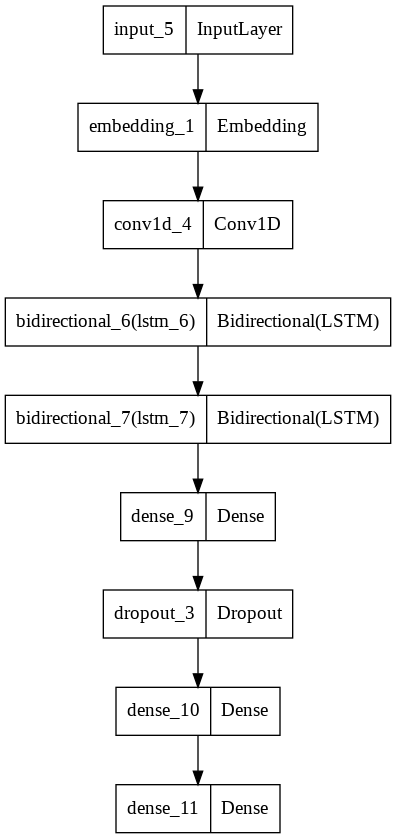

In [121]:
tf.keras.utils.plot_model(model)

In [122]:
# Optimize the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [124]:
# Train the LSTM Model
history = model.fit(X_train_padded,
                    y_train_LSTM,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_val_padded, y_val_LSTM),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
6/6 [==============================] - 31s 3s/step - loss: 0.6903 - accuracy: 0.5544 - val_loss: 0.6836 - val_accuracy: 0.5817
Epoch 2/100
6/6 [==============================] - 15s 3s/step - loss: 0.6841 - accuracy: 0.5675 - val_loss: 0.6753 - val_accuracy: 0.5817
Epoch 3/100
6/6 [==============================] - 15s 3s/step - loss: 0.6783 - accuracy: 0.5675 - val_loss: 0.6634 - val_accuracy: 0.5817
Epoch 4/100
6/6 [==============================] - 15s 3s/step - loss: 0.6663 - accuracy: 0.5713 - val_loss: 0.6422 - val_accuracy: 0.6271
Epoch 5/100
6/6 [==============================] - 15s 3s/step - loss: 0.6441 - accuracy: 0.6309 - val_loss: 0.6073 - val_accuracy: 0.7183
Epoch 6/100
6/6 [==============================] - 15s 3s/step - loss: 0.6088 - accuracy: 0.7213 - val_loss: 0.5644 - val_accuracy: 0.7544
Epoch 7/100
6/6 [==============================] - 15s 3s/step - loss: 0.5635 - accuracy: 0.7599 - val_loss: 0.5342 - val_accuracy: 0.7472
Epoch 8/100
6/6 [==========

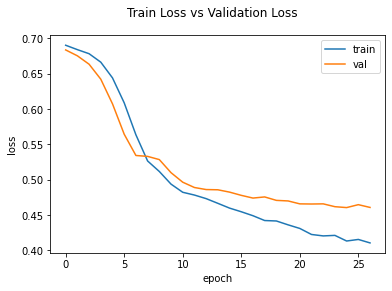

In [125]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.suptitle("Train Loss vs Validation Loss")
plt.legend(['train', 'val'])
plt.show()

In [126]:
model = tf.keras.models.load_model('best-lstm-model.h5')

In [127]:
sample_submission = pd.read_csv("./sample_submission.csv")
predictions = model.predict(X_test_padded)
threshold = 0.6
sample_submission["target"] = (predictions[:,0] > threshold).astype(np.int)

In [128]:
sample_submission.to_csv('./submission.csv', index=False)
sample_submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,0


In [129]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using Double-Bidirectional ConvLSTM, with spell check, threshold 0.6"

100% 22.2k/22.2k [00:00<00:00, 53.8kB/s]
400 - Bad Request


## Results

![image](https://user-images.githubusercontent.com/76294398/149789993-481418cc-dc4f-40e6-bff4-2d872f14b613.png)


## References.

1. Convolutional Neural Networks for Sentence Classification (Kim et al. EMNLP 2014)
> https://paperswithcode.com/paper/convolutional-neural-networks-for-sentence

2. Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download)
> [glove.twitter.27B.zip](https://nlp.stanford.edu/data/glove.twitter.27B.zip)

3. Petumm.Inc: Embeddings: A Matrix of Meaning
> https://petuum.medium.com/embeddings-a-matrix-of-meaning-4de877c9aa27

4. Sai Teja: Stop Words in NLP
> https://medium.com/@saitejaponugoti/stop-words-in-nlp-5b248dadad47

5. 파이썬 정규표현식(re) 사용법 - 05. 주석, 치환, 분리
> https://greeksharifa.github.io/%EC%A0%95%EA%B7%9C%ED%91%9C%ED%98%84%EC%8B%9D(re)/2018/08/04/regex-usage-05-intermediate/#resubpattern-repl-string-count-flags

6. TensorFlow Org.: tf.keras.layers.Conv1D 
> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
